# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

Este é um problema de **previsão de renda** proposto pela EBAC (Escola Britânica de Artes Criativas e Tecnologia).

A partir de uma base com dados de clientes de uma instituição financeira fictícia, nosso objetivo é construir um modelo preditivo para identificar a renda de novos clientes por meio de outras variáveis fornecidas em um cadastro.

O modelo desenvolvido é útil, por exemplo, para avaliar se um cliente seria apto a pegar um empréstimo ou crédito, caso não fosse possível coletar evidências de sua renda.

Então, a partir de uma base com dados de clientes atuais, iremos desenvolver um programa que irá realizar essa previsão.

## Etapa 2 Crisp-DM: Entendimento dos dados
Foram fornecidas 14 variáveis mais a variável resposta (em negrito na tabela). O significado de cada uma dessas variáveis se encontra na tabela.


### Dicionário de dados

Os dados estão dispostos em uma tabela com uma linha para cada cliente e uma coluna para cada variável, armazenando as características desses clientes. Colocamos uma cópia o dicionário de dados (explicação dessas variáveis) abaixo neste notebook:

| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Mês do dado coletado (entre 01/2015 a 03/2016)     | texto        |
| id_cliente              |  Número de identificação do cliente no sistema      | inteiro      |
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    | M/F          |
| posse_de_veiculo        |  Indica se possui veículo (True/False)              | binário      |
| posse_de_imovel         |  Indica se possui imóvel (True/False)               | binário      |
| qtd_filhos              |  Quantidade de filhos                               | inteiro      |
| tipo_renda              |  Tipo de renda (ex: assalariado, empresário etc)    | texto        |
| educacao                |  Nível de educação (ex: secundário, superior etc)   | texto        |
| estado_civil            |  Estado civil (ex: solteiro, casado etc)            | texto        |
| tipo_residencia         |  Tipo de residência (ex: casa, com os pais etc)     | texto        |
| idade                   |  Idade em anos                                      | inteiro      |
| tempo_emprego           |  Tempo de emprego em anos                           | float        |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | inteiro      |
| **renda**               |  Valor da renda mensal do cliente                   | float        |


### Carregando os pacotes

In [1]:
import pandas as pd

from ydata_profiling import ProfileReport
import os

import numpy as np
import statsmodels.formula.api as smf
import patsy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Carregando os dados

In [2]:
df = pd.read_csv('./input/previsao_de_renda.csv')
df.head(5)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


### Criando um Profile
Criamos um relatório do tipo "profile" para observar a disposição dos dados e entender os primeiros passos da limpeza. O arquivo estará salvo na pasta "output" gerada pelo código abaixo.

In [3]:
prof = ProfileReport(df, explorative=True, minimal=True)
os.makedirs('./output', exist_ok=True)
prof.to_file('./output/renda_analisys.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Com o relatório gerado no HTML recebemos 3 alertas importantes para a fase de limpeza de dados:
1. A variável "Unnamed: 0"  possui valores únicos, ou seja, vai do 0 até 14999. Provavelmente esse era o número da linha no sistema em que a base foi originalmente extraída. Esta variável deve ser eliminada na etapa de limpeza.
2. A variável "tempo_emprego" tem 17.2% valores faltantes, precisamos investigar.
3. A variável "qtd_filhos" tem 10376 zeros, o que corresponde a 69.2% da base. Apesar do alerta, isso não é um problema, pois não ter filhos não é um dado que foge da realidade.

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Precisamos eliminar variáveis que não serão usadas.
 - **limpeza**: Precisamos identificar dados faltantes e decidir o melhor tratamento.
 - **construção**: Criamos variáveis que podem ser úteis no projeto.
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: O campo de "datas" pode ser alterado para um formato mais apropriado.
 

#### 1. Deletando os dados da coluna "Unnamed: 0":

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

#### 2. Investigando os valores faltantes de "tempo_emprego". É possível que tenha relação com "tipo de renda".

In [5]:
df2 = df
df2['tempo_emprego_null'] = df2['tempo_emprego'].isnull()
pd.crosstab(df2['tipo_renda'], df['tempo_emprego_null'])

tempo_emprego_null,False,True
tipo_renda,,
Assalariado,7633,0
Bolsista,9,0
Empresário,3508,0
Pensionista,9,2573
Servidor público,1268,0


A suspeita estava correta! Os valores faltantes estão concentrados somente em indivíduos que são pensionistas. Como nosso objetivo é montar um modelo preditivo com machine learning, vamos optar por manter o valor nulo, já que se fosse substituido por "zero" isso afetaria a previsão do modelo de regressão que utilizaremos.

#### 3. Transformando o campo de data no formato apropriado.

In [6]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

#### 4. Criando a variável ln(renda) que utilizaremos posteriormente.

In [7]:
df['log_renda'] = np.log(df['renda'])

## Etapa 4 Crisp-DM: Modelagem

### Selecionando a técnica de modelagem

Neste projeto utilizaremos um modelo de **regressão**, por ser comumente utilizado para fazer previsões futuras com base em dados históricos, identificando padrões e tendências nos dados. 

Iremos treinar (fit) o modelo a partir da base, incluindo ou removendo dados de acordo com a sua significância estatística, avaliada em P-value.

Após isso, iremos avaliar a qualidade do modelo por meio de R².

### Desenhando o modelo

A príncípio, incluiremos todas as variáveis no modelo para entender o comportamento inicial da regressão:

In [8]:
reg = smf.ols('''renda ~ 
                sexo
                + posse_de_veiculo
                + posse_de_imovel
                + qtd_filhos
                + tipo_renda
                + educacao
                + estado_civil
                + tipo_residencia
                + idade
                + tempo_emprego 
                + qt_pessoas_residencia''',
              data = df).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     178.0
Date:                Fri, 02 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:05:21   Log-Likelihood:            -1.2879e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12402   BIC:                         2.578e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -5626.6247   2500.235     -2.250      0.024   -1.05e+04    -725.776
sexo[T.M]                         6052.8592    155.859     38.836      0.000    5747.352    6358.367
posse_de_veiculo[T.True]            48.9098    150.374      0.325      0.745    -245.846     343.666
posse_de_imovel[T.True]            366.5747    148.723      2.465      0.014      75.054     658.095
tipo_renda[T.Bolsista]           -1357.7175   2564.833     -0.529      0.597   -6385.188    3669.753
tipo_renda[T.Empresário]           823.1460    158.826      5.183      0.000     511.822    1134.470
tipo_renda[T.Pensionista]        -2682.6331   2565.489     -1.046      0.296   -7711.391    2346.125
tipo_renda[T.Servidor público]     137.0942    236.327      0.580      0.562    -326.143     600.332
educacao[T.Pós graduação]         1090.5064   1690.396      0.645      0.519   -2222.932    4403.945
educacao[T.Secundário]             607.3280    765.686      0.793      0.428    -893.536    2108.192
educacao[T.Superior completo]     1225.5587    768.564      1.595      0.111    -280.947    2732.064
educacao[T.Superior incompleto]    220.4722    827.097      0.267      0.790   -1400.767    1841.712
estado_civil[T.Separado]          1161.1096   1182.969      0.982      0.326   -1157.693    3479.912
estado_civil[T.Solteiro]           819.9016   1158.206      0.708      0.479   -1450.362    3090.165
estado_civil[T.União]             -475.3334    267.717     -1.776      0.076   -1000.101      49.434
estado_civil[T.Viúvo]             1053.5626   1229.396      0.857      0.391   -1356.245    3463.370
tipo_residencia[T.Casa]           -298.3088    575.821     -0.518      0.604   -1427.008     830.390
tipo_residencia[T.Com os pais]    -388.7990    641.844     -0.606      0.545   -1646.914     869.316
tipo_residencia[T.Comunitário]    -459.8284   1120.521     -0.410      0.682   -2656.224    1736.567
tipo_residencia[T.Estúdio]          77.2381   1056.186      0.073      0.942   -1993.051    2147.527
tipo_residencia[T.Governamental]    73.8042    701.702      0.105      0.916   -1301.641    1449.249
qtd_filhos                       -1126.6107   1147.916     -0.981      0.326   -3376.703    1123.482
idade                               42.0025      8.517      4.931      0.000      25.307      58.698
tempo_emprego                      554.7551     11.044     50.230      0.000     533.107     576.404
qt_pessoas_residencia             1269.8493   1145.868      1.108      0.268    -976.229    3515.928
==============================================================================
Omnibus:                    17568.773   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9884998.164
Skew:             

**Transformação 1:** Iremos aplicar log à variável resposta, assumindo que a relação entre ela e as demais variáveis não é linear e buscando reduzir o impacto de outliers.

In [9]:
reg = smf.ols('''np.log(renda) ~ 
                sexo
                + posse_de_veiculo
                + posse_de_imovel
                + qtd_filhos
                + tipo_renda
                + educacao
                + estado_civil
                + tipo_residencia
                + idade
                + tempo_emprego 
                + qt_pessoas_residencia''',
              data = df).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     287.5
Date:                Fri, 02 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:05:21   Log-Likelihood:                -13568.
No. Observations:               12427   AIC:                         2.719e+04
Df Residuals:                   12402   BIC:                         2.737e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            6.5847      0.235     28.006      0.000       6.124       7.046
sexo[T.M]                            0.7874      0.015     53.723      0.000       0.759       0.816
posse_de_veiculo[T.True]             0.0441      0.014      3.119      0.002       0.016       0.072
posse_de_imovel[T.True]              0.0829      0.014      5.926      0.000       0.055       0.110
tipo_renda[T.Bolsista]               0.2209      0.241      0.916      0.360      -0.252       0.694
tipo_renda[T.Empresário]             0.1551      0.015     10.387      0.000       0.126       0.184
tipo_renda[T.Pensionista]           -0.3087      0.241     -1.280      0.201      -0.782       0.164
tipo_renda[T.Servidor público]       0.0576      0.022      2.591      0.010       0.014       0.101
educacao[T.Pós graduação]            0.1071      0.159      0.673      0.501      -0.205       0.419
educacao[T.Secundário]              -0.0141      0.072     -0.196      0.844      -0.155       0.127
educacao[T.Superior completo]        0.0938      0.072      1.298      0.194      -0.048       0.235
educacao[T.Superior incompleto]     -0.0432      0.078     -0.555      0.579      -0.196       0.109
estado_civil[T.Separado]             0.3265      0.111      2.935      0.003       0.108       0.545
estado_civil[T.Solteiro]             0.2672      0.109      2.453      0.014       0.054       0.481
estado_civil[T.União]               -0.0343      0.025     -1.361      0.174      -0.084       0.015
estado_civil[T.Viúvo]                0.3689      0.116      3.191      0.001       0.142       0.596
tipo_residencia[T.Casa]             -0.0442      0.054     -0.815      0.415      -0.150       0.062
tipo_residencia[T.Com os pais]      -0.0258      0.060     -0.427      0.670      -0.144       0.093
tipo_residencia[T.Comunitário]      -0.1196      0.105     -1.135      0.256      -0.326       0.087
tipo_residencia[T.Estúdio]           0.0665      0.099      0.670      0.503      -0.128       0.261
tipo_residencia[T.Governamental]    -0.0571      0.066     -0.865      0.387      -0.186       0.072
qtd_filhos                          -0.2658      0.108     -2.463      0.014      -0.477      -0.054
idade                                0.0053      0.001      6.624      0.000       0.004       0.007
tempo_emprego                        0.0617      0.001     59.398      0.000       0.060       0.064
qt_pessoas_residencia                0.2926      0.108      2.716      0.007       0.081       0.504
==============================================================================
Omnibus:                        0.858   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.651   Jarque-Bera (JB):                0.839
Skew:             

**Transformação 2:** Vamos remover variáveis que não são estatisticamente significantes (com p-value acima de 0.05):

In [10]:
reg = smf.ols('''np.log(renda) ~ 
                sexo
                + posse_de_veiculo
                + posse_de_imovel
                + qtd_filhos
                + (tipo_renda == 'Empresário')
                + (tipo_renda == 'Servidor público')
                + (educacao == 'Superior completo')
                + (estado_civil == 'Separado')
                + (estado_civil == 'Solteiro')
                + (estado_civil == 'Viúvo')
                + idade
                + tempo_emprego 
                + qt_pessoas_residencia''',
              data = df).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     530.1
Date:                Fri, 02 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:05:22   Log-Likelihood:                -13572.
No. Observations:               12427   AIC:                         2.717e+04
Df Residuals:                   12413   BIC:                         2.728e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    6.5154      0.218     29.853      0.000       6.088       6.943
sexo[T.M]                                    0.7897      0.015     54.092      0.000       0.761       0.818
posse_de_veiculo[T.True]                     0.0455      0.014      3.230      0.001       0.018       0.073
posse_de_imovel[T.True]                      0.0833      0.014      6.077      0.000       0.056       0.110
tipo_renda == 'Empresário'[T.True]           0.1550      0.015     10.413      0.000       0.126       0.184
tipo_renda == 'Servidor público'[T.True]     0.0591      0.022      2.661      0.008       0.016       0.103
educacao == 'Superior completo'[T.True]      0.1096      0.014      8.078      0.000       0.083       0.136
estado_civil == 'Separado'[T.True]           0.3313      0.111      2.979      0.003       0.113       0.549
estado_civil == 'Solteiro'[T.True]           0.2709      0.109      2.489      0.013       0.058       0.484
estado_civil == 'Viúvo'[T.True]              0.3713      0.116      3.213      0.001       0.145       0.598
qtd_filhos                                  -0.2657      0.108     -2.462      0.014      -0.477      -0.054
idade                                        0.0054      0.001      6.939      0.000       0.004       0.007
tempo_emprego                                0.0617      0.001     59.468      0.000       0.060       0.064
qt_pessoas_residencia                        0.2931      0.108      2.721      0.007       0.082       0.504
==============================================================================
Omnibus:                        0.824   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.808
Skew:                           0.019   Prob(JB):                        0.668
Kurtosis:                       3.010   Cond. No.                     2.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Etapa 5 Crisp-DM: Avaliação dos resultados


### Avaliação de R²

O modelo obteve um valor de 0.357 em R², o que significa que aproximadamente 35.7% da variabilidade na variável dependente é explicada pelas variáveis independentes incluídas no modelo.

Ou seja, 35.7% da variação do **log da renda** pode ser explicado pelo conjunto de variáveis que selecionamos.

A maioria das variáveis selecionadas possui um coeficiente positivo na regressão. Ou seja, se o cliente possuir uma das características abaixo, provavelmente sua renda será mais alta, mas se não as tiver, de acordo com o modelo, sua renda tendereá a ser mais baixa.

### Variáveis Categóricas

Caracteristicas que, de acordo com o modelo são relacionadas a uma renda mais alta:
- Sexo Masculino
- Possuir Veículo
- Possuir Imóvel
- Ser Empresário ou Servidor Público
- Possuir Ensino Superior Completo
- Possuir estado civíl Separado, Solteiro ou Viúvo

Intuivamente algumas dessas variáveis fazem bastante sentido:
- A renda na sociedade tende a ser mais concentradas em homens do que mulheres
- Possuir um imóvel ou um veículo indica um poder aquisito maior, que seria relacionado a uma maior renda
- Ser Empresário ou Servidor Público são carreiras que parecem dar um maior retorno de renda do que ser Assalariado, Pensionista ou Bolsista.
- Possuir Ensino Superior Completo geralmente está associada a uma maior renda. 

A variável menos intuitíva é a do Estado Cívil: Por que Solteiros, Viúvos e Separados teriam mais renda do que Casados e com União Estável? Talvez individuos Casados ou com União Estável separam parte do tempo para estar com seus companheiros e por isso investem menos tempo em buscar uma renda maior? Talvez, mas é difícil assumir hipóteses somente com os dados presentes.

É relevante destacar que a categoria "Sexo" tem o maior coeficiente entre as variáveis (0.7897), o que significa que ter sexo masculino ou feminino é um dos fatores que maior influência na renda de acordo com o modelo. 

A partir das conclusões acimas, vamos verificar com o pacote **Seaborn** se o resultado da regressão faz sentido com o que encontramos na base:

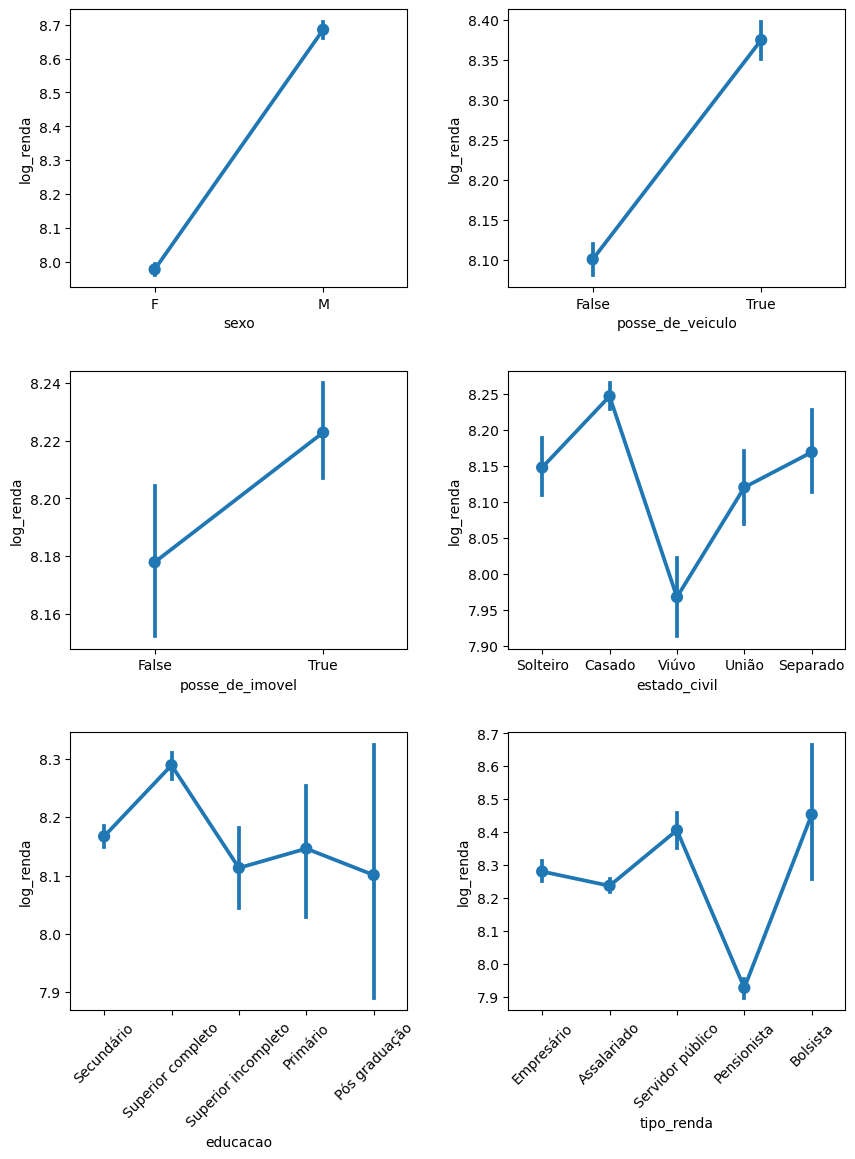

In [11]:
plt.rc('figure', figsize=(10, 13)) #ajustando o tamanho
fig, axes = plt.subplots(3, 2) #abrindo um novo figure 3x2

#gerando vários pointplots
sns.pointplot(ax = axes[0, 0], x='sexo',  y="log_renda", data=df)
sns.pointplot(ax = axes[0, 1], x='posse_de_veiculo',  y="log_renda", data=df)
sns.pointplot(ax = axes[1, 0], x='posse_de_imovel',  y="log_renda", data=df)
sns.pointplot(ax = axes[1, 1], x='estado_civil',  y="log_renda", data=df)
sns.pointplot(ax = axes[2, 0], x='educacao',  y="log_renda", data=df)
sns.pointplot(ax = axes[2, 1], x='tipo_renda',  y="log_renda", data=df)


#Ajustando legendas apertadas
axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45)
axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=45)


#ajustar o espaçamento
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

Os gráficos do tipo "pointplot" acima apresenta estimativas como pontos barras de erro em torno dessas estimativas. O quão menor a barra de erro, mais certeza temos da estimativa.

Comparando os gráficos acima com as indicações do modelo:

**1. Sexo:** É coerente com o que foi apresentado no modelo, pois individuos do sexo Masculino estão associados a rendas maiores do que individuos do sexo Feminino com barras de erro muito pequenas.

**2. Posse de Veículo:** O mesmo acontece aqui. É seguro afirmar que quem tem veículo possui renda maior que quem não possui.

**3. Posse de Imóvel:** O efeito aqui parece similar, mas notamos que as barras de erro são bem maiores, então não é um resultado tão seguro quanto aquele apresentado por "sexo" ou por "posse de veículo".

**4. Estado civil:** Esse gráfico não se comporta como esperado pelo modelo, pois "Viúvo" estava com um coefiente positivo, no entando vemos claramente no gráfico que "Viúvos" tendem a ter uma renda menor (com uma margem de segurança clara mostrada pela barra de erro), evidenciando um possível equivoco do modelo.

**5. Educação:** Como esperado, vemos que o ensino "Superior Completo" possui um log de renda maior associado. É curioso ver que os ensinos "superior incompleto", "primário" e, principalmente, "pós graduação" possuem barras de erros grandes, indicando que não é tão simples estimar a renda de pessoas somente pela classificação da sua educação. Outra observação curiosa é que apesar de "secundário" ter uma barra de erro pequena, quando a adicionamos no modelo ela não se mostra estatisticamente significante. Incluirei o exemplo abaixo.

**5. Tipo de Renda:** Vemos que o "Servidor público", como esperado, costuma ter uma renda maior. Notamos que "Bolsista" tem uma barra de erro bem grande, mas que apesar de "Assalariado" e "Pensionista" terem barras de erro pequenas, incluí-las no modelo não traz resultados com p-value baixo o suficiente para termos confiança estatística nelas.

In [12]:
# Exemplo incluindo "Secundário" (educacao), "Assalariado" (tipo_renda) e "Pensiosita" (tipo_renda) na regressão

# Observamos que suas estimativas não possuem p-value abaixo de 0.05, ou seja
# não são consideradas estatisticamente significativas a um nível de confiança de 95%

reg = smf.ols('''np.log(renda) ~ 
                sexo
                + posse_de_veiculo
                + posse_de_imovel
                + qtd_filhos
                + (tipo_renda == 'Empresário')
                + (tipo_renda == 'Servidor público')
                + (educacao == 'Superior completo')
                + (educacao == 'Secundário')
                + (tipo_renda == 'Assalariado')
                + (tipo_renda == 'Pensionista')
                + (estado_civil == 'Separado')
                + (estado_civil == 'Solteiro')
                + (estado_civil == 'Viúvo')
                + idade
                + tempo_emprego 
                + qt_pessoas_residencia''',
              data = df).fit()

reg.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
No. Observations:               12427   F-statistic:                     430.9
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    6.7284      0.326     20.627      0.000       6.089       7.368
sexo[T.M]                                    0.7899      0.015     54.103      0.000       0.761       0.818
posse_de_veiculo[T.True]                     0.0458      0.014      3.252      0.001       0.018       0.073
posse_de_imovel[T.True]                      0.0828      0.014      6.036      0.000       0.056       0.110
tipo_renda == 'Empresário'[T.True]          -0.0696      0.241     -0.289      0.773      -0.543       0.403
tipo_renda == 'Servidor público'[T.True]    -0.1658      0.242     -0.686      0.493      -0.640       0.308
educacao == 'Superior completo'[T.True]      0.1252      0.030      4.209      0.000       0.067       0.183
educacao == 'Secundário'[T.True]             0.0172      0.029      0.590      0.555      -0.040       0.075
tipo_renda == 'Assalariado'[T.True]         -0.2247      0.241     -0.932      0.352      -0.697       0.248
tipo_renda == 'Pensionista'[T.True]         -0.5355      0.341     -1.571      0.116      -1.204       0.133
estado_civil == 'Separado'[T.True]           0.3312      0.111      2.978      0.003       0.113       0.549
estado_civil == 'Solteiro'[T.True]           0.2726      0.109      2.504      0.012       0.059       0.486
estado_civil == 'Viúvo'[T.True]              0.3719      0.116      3.218      0.001       0.145       0.598
qtd_filhos                                  -0.2655      0.108     -2.460      0.014      -0.477      -0.054
idade                                        0.0053      0.001      6.751      0.000       0.004       0.007
tempo_emprego                                0.0617      0.001     59.470      0.000       0.060       0.064
qt_pessoas_residencia                        0.2929      0.108      2.719      0.007       0.082       0.504
============================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Variáveis Quantitativas

Em relação as variáveis quantitativas temos que:

1. A quantidade de filhos está inversamente relacionada com o log da renda (-0.2657).
2. A idade está positivamente relacionado com o log da renda (mas em pequena escala) (0.0054).
3. O tempo de emprego é a variável quantitativa que mais está relacionada com o log da renda (0.0617).
4. A quantidade de pessoas na residência está relacionada positivamente com o log da renda (0.2931).

**Consideração 1 (Idade + Tempo de Emprego):**
Faz sentido a idade e o tempo de emprego estarem positivamente relacionados com a remuneração, afinal, conforme aumentamos as nossas experiências ou tempo de dedicação a um emprego, a tendência apontada pelo modelo é que geralmente se teria mais renda por isso.

**Consideração 2 (Quantidade de filhos VS Quantidade de Pessoas na Residência):**
Algo que não é tão intuitivo é o porquê de a quantidade de filhos ter um efeito negativo no log da renda e a quantidade de pessoas na residência ter um efeito positivo se, um aumento na quantidade de filhos seria também um aumento na quantidade de pessoas na residência? Isso também é algo que o presente modelo não explica bem.

Vamos analisar o comportamento dessas variáveis individualmente em relação ao log da renda:

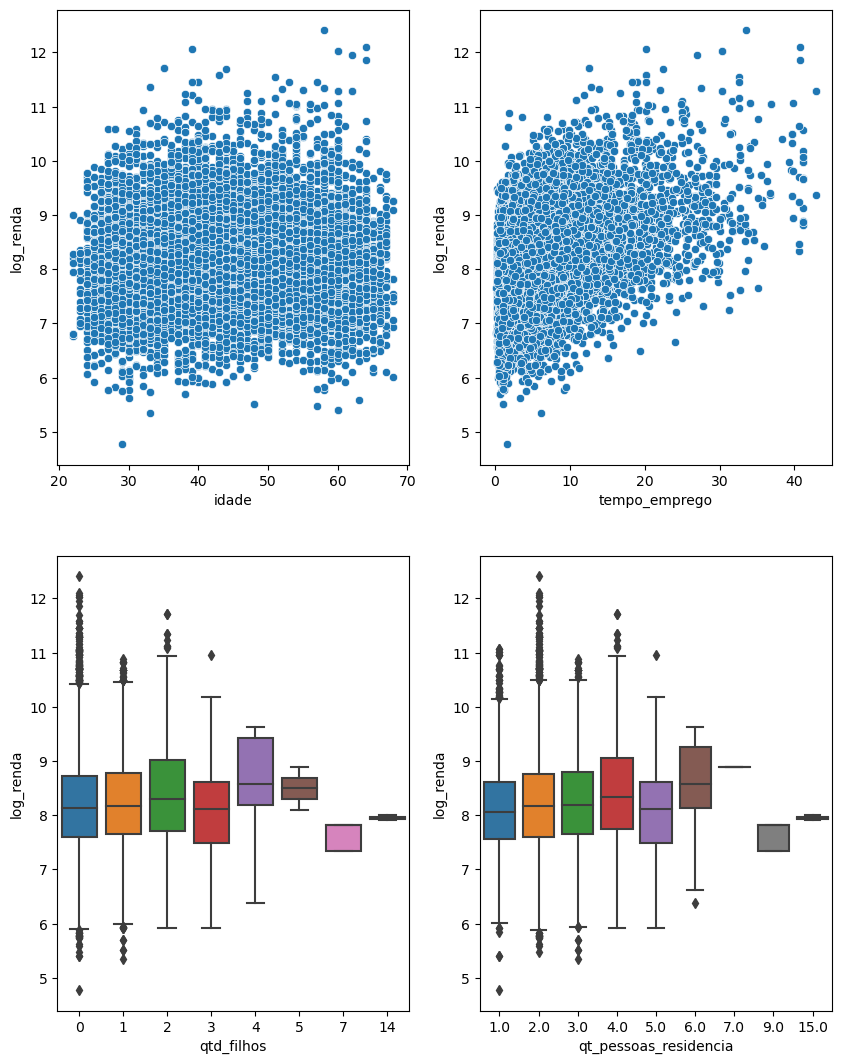

In [13]:
plt.rc('figure', figsize=(10, 13)) #ajustando o tamanho
fig, axes = plt.subplots(2, 2) #abrindo um novo figure 3x2

#gerando vários countplots
sns.scatterplot(ax = axes[0, 0], x='idade',  y="log_renda", data=df)
sns.scatterplot(ax = axes[0, 1], x='tempo_emprego',  y="log_renda", data=df)
sns.boxplot(ax = axes[1, 0], x='qtd_filhos',  y="log_renda", data=df)
sns.boxplot(ax = axes[1, 1], x='qt_pessoas_residencia',  y="log_renda", data=df)

plt.show()

Nos gráficos acima vemos que:

1. A relação de log_renda com idade é visualmente quase imperceptível, o que condiz com o coeficiente do modelo ser 0.0054 para essa variável.

2. A relação de log_renda com tempo_emprego é bem clara, o que também condiz com o coeficiente ser 0.0617 (o segundo maior coeficiente do modelo, tirando apenas "sexo").

3. A relação de quantidade de filhos e quantidade de pessoas na residência com o log da renda não é muito visualmente clara, o que pode ser associado a ambiguidade apresentada pelos coeficientes. Também observamos que há uma multicolinearidade clara entre as duas variáveis. Apesar de ambas serem estatisticamente significantes, não precisamos incluir as duas no modelo.

## Etapa 6 Crisp-DM: Implantação

A fase de implementação (em que normalmente se implementa o modelo desenvolvido em um motor que toma as decisões com algum nível de automação) teria que ser feita com muito cuidado pelos seguintes fatores:

1) O nível de R² é de 0.357, o que significa que há mais de 60% dos fatores do log da renda que não são explicados pelo modelo. 
2) O modelo atribui um valor negativo a estimativa de renda associado ao gênero feminino. Se a estimativa do modelo for utilizada para fornecer algum serviço ou vantagem da instituição financeira, isso pode ser considerado discriminação de gênero.
3) O modelo faz a estimativa do log da renda. Realizamos essa transformação para linearizar a relação entre algumas variáveis, porém, dependendo do uso do modelo, pode ser necessário realizar uma transformação de volta em renda (sem o log) para realizar as ponderações necessárias.